## Crude Oil Price Forecasting

In [194]:
import pandas as pd
import numpy as np
import scipy
import torch
import os
import scipy
import datetime
import matplotlib.pyplot as plt

### Data Preparation

In [206]:
# Dated brent data
dated_brent_data = pd.read_csv(os.path.join('data', 
                                            'dated_brent_allbate.csv')
                              ).rename({'assessDate':'Date'}, axis=1
                                      ).drop(columns=['Unnamed: 0', 
                                                      'isCorrected', 
                                                      'modDate', 
                                                      'symbol'])

dated_c = dated_brent_data[dated_brent_data['bate'] == 'c'].drop(columns=['bate']).rename({'value':'Closing'}, axis=1)
dated_h = dated_brent_data[dated_brent_data['bate'] == 'h'].drop(columns=['bate']).rename({'value':'High'}, axis=1)
dated_l = dated_brent_data[dated_brent_data['bate'] == 'l'].drop(columns=['bate']).rename({'value':'Low'}, axis=1)

dated_brent_data = dated_c.merge(dated_h, on="Date").merge(dated_l, on="Date")
dated_brent_data['Date'] = pd.to_datetime(dated_brent_data['Date'])

# Date conversion

def convert_date(date):
    format = '%m/%d/%Y'
    date_converted = datetime.datetime.strptime(date, format).date()

    return date_converted

# # Crude oil volatility data
# crude_volatility_data = pd.read_csv(os.path.join('data', 'cboe_ovx_futures.csv')
#                                    ).drop(columns=['Unnamed: 0', 'Volume', 'Open'])
# crude_volatility_data['Date'] = pd.to_datetime(crude_volatility_data['Date'].apply(convert_date))

# News data

# --- #

# Brent futures data
brent_futures_data = pd.read_csv(os.path.join('data', 'brent_nmx.csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
brent_futures_data['Date'] = pd.to_datetime(brent_futures_data['Date'].apply(convert_date))

# Gasoline futures data
gasoline_data = pd.read_csv(os.path.join('data', 'gasoline_nmx.csv')
                           ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
gasoline_data['Date'] = pd.to_datetime(gasoline_data['Date'].apply(convert_date))

# Dollar Index data
dollar_data = pd.read_csv(os.path.join('data', 'dollar_index.csv')
                         ).drop(columns=['Adj Close', 'Volume', 'Open']).dropna().drop_duplicates()
dollar_data['Date'] = pd.to_datetime(dollar_data['Date'])

# U.S. Crude Oil Production data
production_data = pd.read_csv(os.path.join('data', 'U.S._Crude_Production_ThousandPerDay.csv'), delimiter = ',')

# GPR 
gpr_data = pd.read_excel(os.path.join('data', 'data_gpr_daily_recent.xlsx')).drop(columns=['event', 'var_name', 'var_label', 'N10D', 'DAY']).rename({'date':'Date'}, axis=1)

# Gold Price
gold_price_data = pd.read_csv(os.path.join('data', 'GoldPrice.csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'].apply(convert_date))

# Silver Price
silver_price_data = pd.read_csv(os.path.join('data', 'Silver(CMX).csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
silver_price_data['Date'] = pd.to_datetime(silver_price_data['Date'].apply(convert_date))

# Platinum Price
platinum_price_data = pd.read_csv(os.path.join('data', 'Platinum(NMX).csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
platinum_price_data['Date'] = pd.to_datetime(platinum_price_data['Date'].apply(convert_date))

# Platinum Price
palladium_price_data = pd.read_csv(os.path.join('data', 'Palladium(NMX).csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
palladium_price_data['Date'] = pd.to_datetime(palladium_price_data['Date'].apply(convert_date))


# US Bond Rate
us_bond_data = pd.read_csv(os.path.join('data', 'USBondRate.csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
us_bond_data['Date'] = pd.to_datetime(us_bond_data['Date'].apply(convert_date))

# S&P500
sp500_data = pd.read_csv(os.path.join('data', 'S&P500 (SPX).csv')
                                ).drop(columns=['Open']).rename({'Close/Last':'Close'},axis=1)
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'].apply(convert_date))

# EUR to USD
eur_usd_data = pd.read_csv(os.path.join('data', 'EURUSD.csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
eur_usd_data['Date'] = pd.to_datetime(eur_usd_data['Date'].apply(convert_date))

# Gold miners
gold_miners_data = pd.read_csv(os.path.join('data', 'GoldMiners(GDX).csv')
                                ).drop(columns=['Open', 'Volume']).rename({'Close/Last':'Close'},axis=1)
gold_miners_data['Date'] = pd.to_datetime(gold_miners_data['Date'].apply(convert_date))

Predictor Variables:
1. Silver Price
2. Platinum Price
3. Palladium Price
4. Gold Price
5. Gold Miners Price
6. S&P500 Price
7. Dollar Index (Closing), Percent Change -> NASDAQ
8. Gasoline (Closing), Percent Change -> NASDAQ
9. ? U.S. Crude Oil Production, MioBarrels/Day -> U.S. Energy Information Administration (EIA)
10. GPR Data, Percent Change -> Economic Policy Uncertainty (EPU)
11. US Bond Rate
12. ? Euro to USD

Target Variable:
Brent Futures (Closing), $ (MA30) -> NASDAQ
Dated Brent Price -> S&P Global Commodity Insights

In [207]:
predictor = gasoline_data.drop(columns=['High', 'Low']).rename({'Close' : 'Gas'}, axis=1).merge(
    dollar_data.drop(columns=['High', 'Low']).rename({'Close' : 'DXY'}, axis=1), on='Date').merge(
    gold_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Gold(CMX)'}, axis=1), on='Date').merge(
    silver_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Silver(CMX)'}, axis=1), on='Date').merge(
    platinum_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Platinum(NMX)'}, axis=1), on='Date').merge(
    palladium_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Palladium(NMX)'}, axis=1), on='Date').merge(
    us_bond_data.drop(columns=['High', 'Low']).rename({'Close' : 'USBond'}, axis=1), on='Date').merge(
    sp500_data.drop(columns=['High', 'Low']).rename({'Close' : 'S&P500'}, axis=1), on='Date').merge(
    gold_miners_data.drop(columns=['High', 'Low']).rename({'Close' : 'GoldMiners'}, axis=1), on='Date').merge(
    gpr_data[['Date', 'GPRD']])

target = brent_futures_data[['Date','Close']].rename({'Close' : 'BrFu'}, axis=1)

df = predictor.merge(target, on ='Date').rename({'Date' : 'date'}, axis=1)
df

date     Gas         DXY  Gold(CMX)  Silver(CMX)  Platinum(NMX)  \
0    2024-08-05  2.3336  102.690002     2444.4       27.207          915.5   
1    2024-08-02  2.3176  103.209999     2469.8       28.392          967.6   
2    2024-08-01  2.3980  104.419998     2480.8       28.477          970.5   
3    2024-07-31  2.4425  104.099998     2473.0       28.938          986.4   
4    2024-07-30  2.3443  104.550003     2451.9       28.525          971.0   
...         ...     ...         ...        ...          ...            ...   
2496 2014-08-29  2.6229   82.750000     1287.4       19.492         1424.7   
2497 2014-08-28  2.5908   82.480003     1290.4       19.609         1425.2   
2498 2014-08-27  2.5905   82.430000     1283.4       19.475         1419.9   
2499 2014-08-26  2.6001   82.650002     1285.2       19.459         1419.6   
2500 2014-08-25  2.5954   82.550003     1278.9       19.431         1418.4   

      Palladium(NMX)    USBond   S&P500  GoldMiners        GPRD   BrFu  
0             826.10  125.4062  5186.33       35.34  210.206711  72.94  
1             882.50  125.0625  5346.56       36.48  207.799438  73.52  
2             895.10  122.5312  5446.68       37.27  139.878098  76.93  
3             925.20  120.7812  5522.30       37.93  135.206848  77.91  
4             881.70  120.1875  5436.44       36.95   95.696396  74.73  
...              ...       ...      ...         ...         ...    ...  
2496          909.55  140.0938  2003.37       26.69  157.336334  95.96  
2497          898.10  141.7188  1996.74       26.46   97.534706  94.55  
2498          894.70  141.1562  2000.12       26.11  143.082108  93.88  
2499          890.15  140.5312  2000.02       26.19  118.143707  93.86  
2500          891.50  140.7188  1997.92       25.62  167.600159  93.35  

[2501 rows x 12 columns]

---

## Modelling

In [208]:
import pandas as pd
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate, NBEATSx
from neuralforecast.losses.pytorch import MSE, MAE, MAPE
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [209]:
# Functions

def createLag(data, amt=10):
    """
    Create a lag inside dataframe, in business days

    Input:
        data -> Pandas dataframe 
        amt -> int

    Output:
        Copy of pandas Dataframe
    """
    if 'ds' in data:
        # Ensure 'ds' is a datetime column
        data['ds'] = pd.to_datetime(data['ds'], errors='coerce')
        
        # Check for any null values after conversion
        if data['ds'].isnull().any():
            print("Warning: Some dates couldn't be converted to datetime.")

        copy = data.copy()
        # Apply the business day offset
        copy['ds'] = copy['ds'] + pd.tseries.offsets.BusinessDay(amt)
        return copy
    else:
        print("No 'ds' column found inside dataframe")
        return data

def trainTestValSplit(data, test_size, val_size):
    """
    Splits data into train-test-validation sets

    Input:
        data -> Pandas dataframe
        test_size -> Proportion of data for test set
        val_size -> Proportiion of data fro validation set

    Output:
        This is not needed yet, actually
    """
    pass

def scaleStandard(df_col):
    """
    Fits and returns a standard scaled version of a dataframe column
    """
    scaler = StandardScaler()
    df_col = scaler.fit_transform(df_col)
    df_col = pd.DataFrame(df_col)
    return df_col, scaler

def logReturn(data, df_col):
    """
    Perform log return for a dataframe column
    """
    new_col = np.log1p(data[df_col].pct_change())
    return new_col

def transformData(data, log_return=[], standard_scale=[]):
    """
    Perform essential transformations towards the dataframe.
    
    Args:
        data (pd.DataFrame): DataFrame with data to be transformed.
        log_return (list): List of columns for which log returns should be computed.
        standard_scale (list): List of columns to be standard scaled.
        
    Returns:
        data (pd.DataFrame): Transformed DataFrame.
        Optional: yScaler if 'y' is in standard_scale.
    """
    y_log_ret = False
    y_std_scale = False

    data.sort_values(by='ds', inplace=True)

    # Apply log return transformation
    if len(log_return) > 0:
        for col1 in log_return:
            try:
                data[col1] = logReturn(data, col1)
            except Exception as e:
                print(f"Error processing log return for column '{col1}': {e}")
                pass
            
        if 'y' in log_return:
            y_log_ret = True

    # Apply standard scaling
    yScaler = None  # Initialize to None
    if len(standard_scale) > 0:
        for col2 in standard_scale:
            try:
                data[col2], _ = scaleStandard(data[[col2]])  # Assuming scaleStandard handles 1D arrays
            except Exception as e:
                print(f"Error processing standard scaling for column '{col2}': {e}")
                pass
            
        if 'y' in standard_scale:
            try:
                data['y'], yScaler = scaleStandard(data['y'])  # Scale 'y' and get scaler
                y_std_scale = True
            except Exception as e:
                print(f"Error processing standard scaling for 'y': {e}")
                pass

    # If 'yScaler' exists, return it along with the transformed data
    if yScaler:
        return data, yScaler

    return data

In [210]:
# Exogenous 

Y_df = df.rename({'date' : 'ds', 'BrFu' : 'y'}, axis=1
                          )
Y_df['unique_id'] = 'Dated'
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# We make validation and test splits
n_time = len(Y_df.ds.unique())
val_size = int(.1 * n_time)
test_size = int(.1 * n_time)

print(f'Total length is {n_time}, with validation and test size of {val_size} for each')

Total length is 2501, with validation and test size of 250 for each


In [211]:
Y_df_test = Y_df.copy().rename({'y' : 'BrFu'}, axis=1)

# Y_df_test = createLag(Y_df_test, amt=30)
last_df = Y_df[['ds', 'y']].merge(Y_df_test, on = 'ds')
last_df

ds      y     Gas         DXY  Gold(CMX)  Silver(CMX)  \
0    2024-08-05  72.94  2.3336  102.690002     2444.4       27.207   
1    2024-08-02  73.52  2.3176  103.209999     2469.8       28.392   
2    2024-08-01  76.93  2.3980  104.419998     2480.8       28.477   
3    2024-07-31  77.91  2.4425  104.099998     2473.0       28.938   
4    2024-07-30  74.73  2.3443  104.550003     2451.9       28.525   
...         ...    ...     ...         ...        ...          ...   
2496 2014-08-29  95.96  2.6229   82.750000     1287.4       19.492   
2497 2014-08-28  94.55  2.5908   82.480003     1290.4       19.609   
2498 2014-08-27  93.88  2.5905   82.430000     1283.4       19.475   
2499 2014-08-26  93.86  2.6001   82.650002     1285.2       19.459   
2500 2014-08-25  93.35  2.5954   82.550003     1278.9       19.431   

      Platinum(NMX)  Palladium(NMX)    USBond   S&P500  GoldMiners  \
0             915.5          826.10  125.4062  5186.33       35.34   
1             967.6          882.50  125.0625  5346.56       36.48   
2             970.5          895.10  122.5312  5446.68       37.27   
3             986.4          925.20  120.7812  5522.30       37.93   
4             971.0          881.70  120.1875  5436.44       36.95   
...             ...             ...       ...      ...         ...   
2496         1424.7          909.55  140.0938  2003.37       26.69   
2497         1425.2          898.10  141.7188  1996.74       26.46   
2498         1419.9          894.70  141.1562  2000.12       26.11   
2499         1419.6          890.15  140.5312  2000.02       26.19   
2500         1418.4          891.50  140.7188  1997.92       25.62   

            GPRD   BrFu unique_id  
0     210.206711  72.94     Dated  
1     207.799438  73.52     Dated  
2     139.878098  76.93     Dated  
3     135.206848  77.91     Dated  
4      95.696396  74.73     Dated  
...          ...    ...       ...  
2496  157.336334  95.96     Dated  
2497   97.534706  94.55     Dated  
2498  143.082108  93.88     Dated  
2499  118.143707  93.86     Dated  
2500  167.600159  93.35     Dated  

[2501 rows x 14 columns]

In [212]:
test_data = transformData(last_df,
                         #log_return = ['y', 'BrFu', 'Gas', 'DXY', 'Gold(CMX)', 'Silver(CMX)', 'Platinum(NMX)', 'Palladium(NMX)', 'USBond', 'S&P500', 'GoldMiners', 'GPRD'],
                         standard_scale = ['y', 'Gas', 'DXY', 'Gold(CMX)', 'Silver(CMX)', 'Platinum(NMX)', 'Palladium(NMX)', 'USBond', 'S&P500', 'GoldMiners', 'GPRD']
                         )
test_data.dropna(inplace=True)
test_data

Error processing standard scaling for 'y': Expected 2D array, got 1D array instead:
array=[0.57819032 0.6095309  0.79379192 ... 1.70969345 1.70861274 1.68105464].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


ds         y       Gas       DXY  Gold(CMX)  Silver(CMX)  \
2500 2014-08-25  0.578190  0.696193  1.014414   2.601005     1.767282   
2499 2014-08-26  0.609531  0.668536  1.114362   2.675076     2.043063   
2498 2014-08-27  0.793792  0.807512  1.346933   2.707154     2.062844   
2497 2014-08-28  0.846747  0.884432  1.285427   2.684408     2.170131   
2496 2014-08-29  0.674914  0.714688  1.371921   2.622877     2.074015   
...         ...       ...       ...       ...        ...          ...   
4    2024-07-30  1.822087  1.196264 -2.818213  -0.773021    -0.028204   
3    2024-07-31  1.745897  1.140777 -2.870109  -0.764272    -0.000975   
2    2024-08-01  1.709693  1.140259 -2.879720  -0.784686    -0.032161   
1    2024-08-02  1.708613  1.156853 -2.837434  -0.779436    -0.035884   
0    2024-08-05  1.681055  1.148729 -2.856654  -0.797808    -0.042401   

      Platinum(NMX)  Palladium(NMX)    USBond    S&P500  GoldMiners      GPRD  \
2500      -0.488608       -0.829241 -1.441077  1.996384    1.317266  1.747204   
2499      -0.048414       -0.742670 -1.461573  2.158139    1.488741  1.702180   
2498      -0.023911       -0.723329 -1.612523  2.259212    1.607570  0.431829   
2497       0.110428       -0.677127 -1.716881  2.335551    1.706845  0.344462   
2496      -0.019687       -0.743898 -1.752285  2.248874    1.559436 -0.394513   
...             ...             ...       ...       ...         ...       ...   
4          3.813639       -0.701149 -0.565209 -1.216868    0.016163  0.758355   
3          3.817864       -0.718724 -0.468305 -1.223561   -0.018432 -0.360130   
2          3.773084       -0.723943 -0.501855 -1.220149   -0.071078  0.491755   
1          3.770549       -0.730927 -0.539126 -1.220250   -0.059045  0.025325   
0          3.760410       -0.728855 -0.527938 -1.222370   -0.144782  0.950322   

       BrFu unique_id  
2500  93.35     Dated  
2499  93.86     Dated  
2498  93.88     Dated  
2497  94.55     Dated  
2496  95.96     Dated  
...     ...       ...  
4     74.73     Dated  
3     77.91     Dated  
2     76.93     Dated  
1     73.52     Dated  
0     72.94     Dated  

[2501 rows x 14 columns]

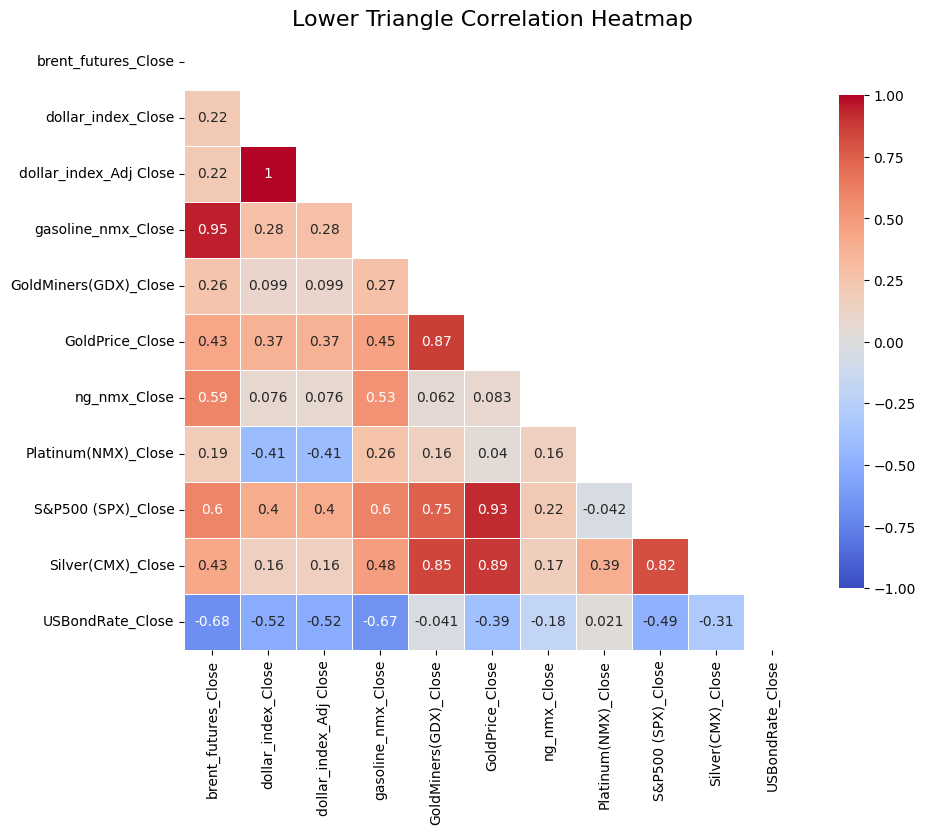

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_correlation_heatmap(df):
    """
    Plot a correlation heatmap for all columns in a pandas DataFrame,
    showing only the lower triangle of the matrix.
    
    Input:
        df -> pandas DataFrame
        
    Output:
        Correlation heatmap (lower triangle)
    """
    corr_matrix = df.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(10, 8))

    # Lower triangle correlation heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})

    plt.title("Lower Triangle Correlation Heatmap", fontsize=16)

    plt.show()

test = pd.read_csv(os.path.join('artifacts', '4b950ff8-8caf-4f33-9a68-345ea4464fc8', 'transformed_dataset.csv'))
# plot_correlation_heatmap(test_data.drop(columns=['ds', 'unique_id']))
plot_correlation_heatmap(test.drop(columns=['Date', 'Unnamed: 0']))

---

## Statsforecast

In [341]:
import pandas as pd
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from statsforecast.arima import arima_string

# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=30, max_p=5, max_d=2, max_q=5, seasonal=True),
]

# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=test_data[['ds','y','unique_id']], 
    models=models,
    freq='D', 
    n_jobs=2
)

forecasts_df = sf.fit().predict(h=30, level=[95])

for model, uid in zip(sf.fitted_, forecasts_df.index.unique()):
    print(uid, ' - ', arima_string(model[0].model_))

forecasts_df

# Check parameters
# https://stackoverflow.com/questions/77436740/statforecast-autoarima-how-to-run-different-models-for-each-unique-ids

e:\VM\miniconda3\envs\multi-its\lib\site-packages\statsforecast\core.py:510: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
e:\VM\miniconda3\envs\multi-its\lib\site-packages\statsforecast\core.py:510: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


Dated  -  ARIMA(5,0,2)(0,0,1)[30] with zero mean    


e:\VM\miniconda3\envs\multi-its\lib\site-packages\statsforecast\core.py:528: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds  AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
unique_id                                                        
Dated     2024-08-06   0.000161        -0.057762         0.058084
Dated     2024-08-07   0.005220        -0.052705         0.063145
Dated     2024-08-08  -0.002106        -0.060039         0.055827
Dated     2024-08-09  -0.002936        -0.061125         0.055254
Dated     2024-08-10  -0.002981        -0.061185         0.055223
Dated     2024-08-11  -0.002235        -0.060556         0.056086
Dated     2024-08-12  -0.001244        -0.059578         0.057090
Dated     2024-08-13  -0.001598        -0.059981         0.056785
Dated     2024-08-14  -0.001097        -0.059480         0.057286
Dated     2024-08-15  -0.000821        -0.059239         0.057597
Dated     2024-08-16  -0.000784        -0.059202         0.057635
Dated     2024-08-17  -0.001267        -0.059713         0.057179
Dated     2024-08-18  -0.001201        -0.059648         0.057245
Dated     2024-08-19  -0.000658        -0.059121         0.057806
Dated     2024-08-20  -0.000674        -0.059138         0.057790
Dated     2024-08-21  -0.000226        -0.058701         0.058248
Dated     2024-08-22  -0.001502        -0.059978         0.056973
Dated     2024-08-23  -0.000578        -0.059061         0.057904
Dated     2024-08-24   0.000512        -0.057971         0.058994
Dated     2024-08-25   0.000194        -0.058294         0.058681
Dated     2024-08-26   0.000129        -0.058359         0.058617
Dated     2024-08-27  -0.000743        -0.059234         0.057748
Dated     2024-08-28  -0.000714        -0.059205         0.057778
Dated     2024-08-29   0.000102        -0.058391         0.058595
Dated     2024-08-30   0.000239        -0.058255         0.058732
Dated     2024-08-31   0.000167        -0.058328         0.058662
Dated     2024-09-01  -0.001718        -0.060214         0.056777
Dated     2024-09-02   0.000138        -0.058358         0.058634
Dated     2024-09-03   0.001258        -0.057239         0.059754
Dated     2024-09-04   0.000057        -0.058440         0.058554

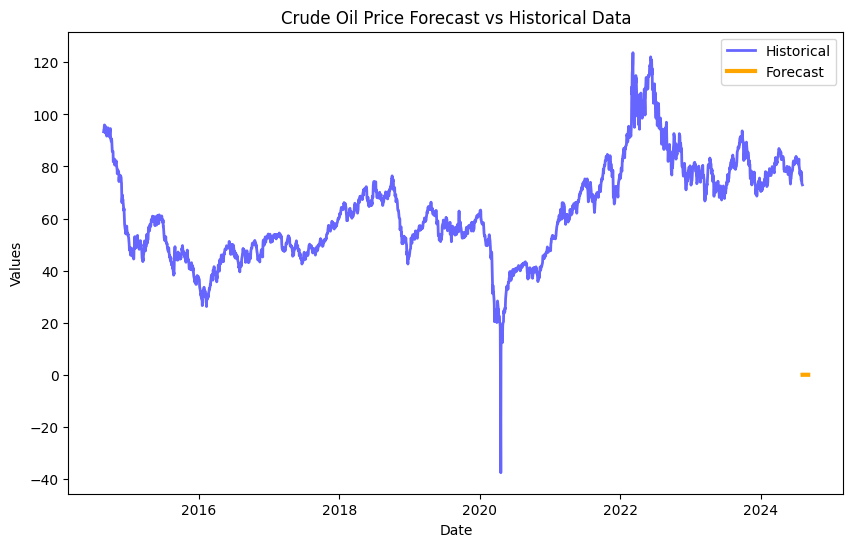

In [342]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecast(test_data, forecasts_df, horizon=30):
    """
    Plots historical data and forecasted values, emphasizing the forecast.
    
    Args:
        test_data (pd.DataFrame): Historical data with columns 'ds' (date) and 'y' (values).
        forecasts_df (pd.DataFrame): Forecasted values with index 'ds' and columns for predictions.
        horizon (int): Number of forecasted steps.
    """
    # Prepare the forecasted data
    forecasted_dates = pd.date_range(test_data['ds'].max(), periods=horizon+1, freq='D')[1:]
    forecasted_values = forecasts_df['AutoARIMA'].values[:horizon]

    # Combine forecasted values with their corresponding dates
    forecast_df = pd.DataFrame({'ds': forecasted_dates, 'forecast': forecasted_values})

    # Plot the historical and forecasted data
    plt.figure(figsize=(10, 6))
    
    # Plot historical data with lighter color and transparency
    plt.plot(test_data['ds'], test_data['y'], label='Historical', color='blue', alpha=0.6, linewidth=2)
    
    # Plot forecasted data with a thicker, dashed line to stand out
    plt.plot(forecast_df['ds'], forecast_df['forecast'], label='Forecast', color='orange' , linewidth=3)
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Crude Oil Price Forecast vs Historical Data')
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage:
plot_forecast(last_df, forecasts_df, horizon=30)

---

## Neuralforecast

In [41]:
horizon = 15
input_size = 30
models = [
    TSMixer(h=horizon,
                input_size=input_size,
                n_series=1,
                max_steps=1000,
                val_check_steps=50,
                early_stop_patience_steps=5,
                scaler_type='identity',
                loss=MAE(),
                valid_loss=MAE(),
                random_seed=12345678,
                ),
    TSMixerx(h=horizon,
                input_size=input_size,
                n_series=1,
                max_steps=1000,
                val_check_steps=50,
                early_stop_patience_steps=5,
                scaler_type='identity',
                dropout=0.7,
                loss=MAE(),
                valid_loss=MAE(),
                random_seed=12345678,
                hist_exog_list=['Gas', 'DXY', 'Gold(CMX)', 'Silver(CMX)', 'Platinum(NMX)', 'Palladium(NMX)', 'USBond', 'S&P500', 'GoldMiners', 'GPRD'],
                ),
    NBEATSx(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=50,
                early_stop_patience_steps=5,
                scaler_type='identity',
                loss=MAE(),
                valid_loss=MAE(),
                random_seed=12345678,
                hist_exog_list=['Gas', 'DXY', 'Gold(CMX)', 'Silver(CMX)', 'Platinum(NMX)', 'Palladium(NMX)', 'USBond', 'S&P500', 'GoldMiners', 'GPRD']
                ),
]

Seed set to 12345678
Seed set to 12345678
Seed set to 12345678


In [42]:
nf = NeuralForecast(
    models=models,
    freq='D')

In [43]:
Y_hat_df = nf.cross_validation(df=last_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None
                               )
Y_hat_df = Y_hat_df.reset_index()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | loss          | MAE                      | 0      | train
1 | valid_loss    | MAE                      | 0      | train
2 | padder        | ConstantPad1d            | 0      | train
3 | scaler        | TemporalNorm             | 0      | train
4 | norm          | ReversibleInstanceNorm1d | 2      | train
5 | mixing_layers | Sequential               | 2.5 K  | train
6 | out           | Linear                   | 465    | train
-------------------------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Epoch 549: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, v_num=12, train_loss_step=3.290, train_loss_epoch=3.290, valid_loss=4.060]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.03it/s]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                     | Params | Mode 
-------------------------------------------------------------------------
0 | loss                | MAE                      | 0      | train
1 | valid_loss          | MAE                      | 0      | train
2 | padder              | ConstantPad1d            | 0      | train
3 | scaler              | TemporalNorm             | 0      | train
4 | norm                | ReversibleInstanceNorm1d | 2      | train
5 | temporal_projection | Linear                   | 465    | train
6 | feature_mixer_hist  | FeatureMixing            | 7.6 K  | train
7 | first_mixing        | MixingLayer              | 12.4 K | train
8 | mixing_block        | Sequential               | 24.8 K | train
9 | out                 | Linear                   | 65     | train
----------------------------------------------------------

Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, v_num=14, train_loss_step=3.880, train_loss_epoch=3.880, valid_loss=6.120]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.88it/s]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
930       Non-trainable params
2.7 M     Total params
10.668    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Epoch 549: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, v_num=16, train_loss_step=2.540, train_loss_epoch=2.540, valid_loss=4.240]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.13it/s] 


e:\VM\miniconda3\envs\multi-its\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [44]:
# Y_hat_df['y'] = yScaler.inverse_transform(Y_hat_df[['y']])
# Y_hat_df['TSMixer'] = yScaler.inverse_transform(Y_hat_df[['TSMixer']])
# Y_hat_df['TSMixerx'] = yScaler.inverse_transform(Y_hat_df[['TSMixerx']])
# Y_hat_df['NBEATSx'] = yScaler.inverse_transform(Y_hat_df[['NBEATSx']])

In [45]:
Y_hat_df

unique_id         ds     cutoff    TSMixer   TSMixerx    NBEATSx      y
0        Dated 2023-08-08 2023-08-07  82.474472  85.802956  82.134666  82.92
1        Dated 2023-08-09 2023-08-07  82.759224  86.319862  82.286011  84.40
2        Dated 2023-08-10 2023-08-07  83.013039  85.747772  82.536789  82.82
3        Dated 2023-08-11 2023-08-07  83.141472  86.653404  82.569160  83.19
4        Dated 2023-08-14 2023-08-07  82.938721  86.651329  82.851303  82.51
...        ...        ...        ...        ...        ...        ...    ...
3535     Dated 2024-07-30 2024-07-15  83.346069  84.194443  83.034058  74.73
3536     Dated 2024-07-31 2024-07-15  83.281624  85.323982  83.138260  77.91
3537     Dated 2024-08-01 2024-07-15  82.876152  84.959213  82.852654  76.93
3538     Dated 2024-08-02 2024-07-15  83.144974  84.943405  82.720123  73.52
3539     Dated 2024-08-05 2024-07-15  83.181046  84.934311  82.854950  72.94

[3540 rows x 7 columns]

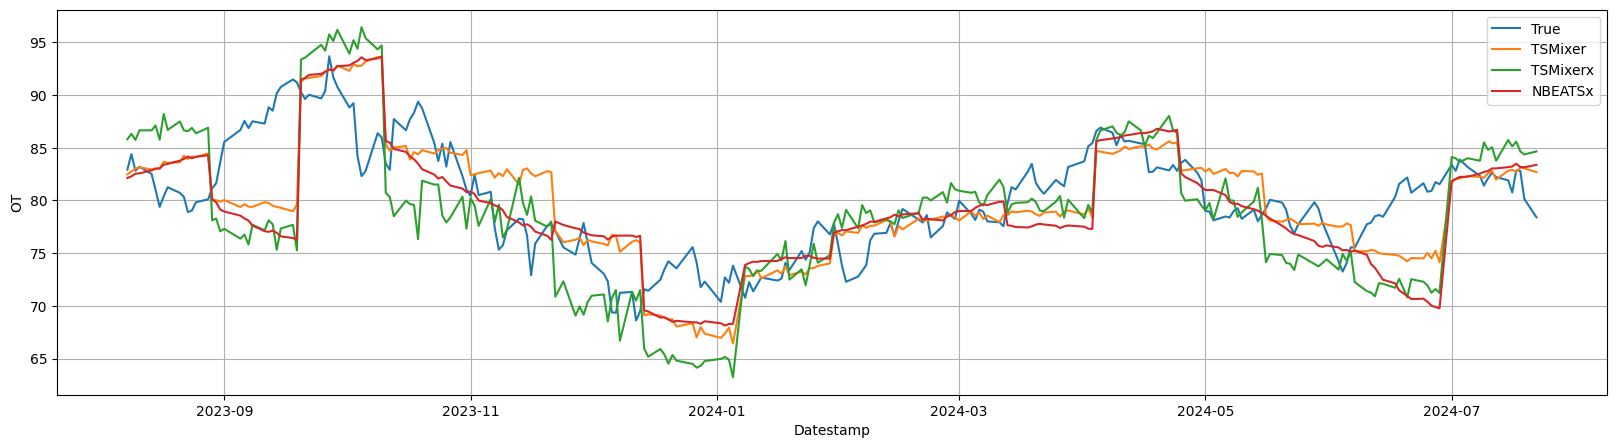

In [46]:
import matplotlib.pyplot as plt
Y_plot = Y_hat_df[Y_hat_df['unique_id']=='Dated']
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
for model in models:
    plt.plot(Y_plot['ds'], Y_plot[f'{model}'], label=f'{model}')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

In [40]:
from neuralforecast.losses.numpy import mse, mae, mape

for model in models:
    mae_model = mae(Y_hat_df['y'], Y_hat_df[f'{model}']) 
    mse_model = mse(Y_hat_df['y'], Y_hat_df[f'{model}'])
    mape_model = mape(Y_hat_df['y'], Y_hat_df[f'{model}'])
    print(f'{model} horizon {horizon} - MAE: {mae_model:.3f}')
    print(f'{model} horizon {horizon} - MSE: {mse_model:.3f}')
    print(f'{model} horizon {horizon} - MAPE: {mape_model:.3f}')

TSMixer horizon 2 - MAE: 1.445
TSMixer horizon 2 - MSE: 3.415
TSMixer horizon 2 - MAPE: 0.018
TSMixerx horizon 2 - MAE: 3.171
TSMixerx horizon 2 - MSE: 14.609
TSMixerx horizon 2 - MAPE: 0.040
NBEATSx horizon 2 - MAE: 1.364
NBEATSx horizon 2 - MSE: 3.087
NBEATSx horizon 2 - MAPE: 0.017


## Hyperparameter Tuning

In [107]:
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import AutoNHITS, AutoTSMixer
from neuralforecast import NeuralForecast

In [96]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Use this to disable training prints from optuna

In [122]:
horizon_len = 12

def config_nhits(trial):
    return {
        "max_steps": 1000,                                                                                               # Number of SGD steps
        "input_size" : trial.suggest_categorical("input_size", [horizon_len, horizon_len*2, horizon_len*3]),                                                                                               # Size of input window
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-1),                                         # Initial Learning rate
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [[2, 2, 2], [16, 8, 1]]),                 # MaxPool's Kernel size
        "n_freq_downsample": trial.suggest_categorical("n_freq_downsample", [[168, 24, 1], [24, 12, 1], [1, 1, 1]]),    # Interpolation expressivity ratios
        "val_check_steps": 50,                                                                                          # Compute validation every 50 steps
        "early_stop_patience_steps": 5,                                                                                 # Stops at 5 steps max if loss doesn't get beter
        "random_seed": trial.suggest_int("random_seed", 1, 10),                                                         # Random seed
    }

def config_tsmixer(trial):
    return {
        "max_steps": 1000,
        "n_series" : 1,
        "input_size" : trial.suggest_categorical("input_size", [horizon_len, horizon_len*2, horizon_len*3]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-1),
        "ff_dim": trial.suggest_categorical("ff_dim", [32,64,128]),
        "n_block": trial.suggest_categorical("n_block", [2,4,8]),
        "val_check_steps": 50,
        "early_stop_patience_steps": 5,
        "scaler_type": 'identity',
    }

In [123]:
model = [AutoNHITS(h=horizon_len,
                  loss=MAE(),
                  valid_loss=MAE(),
                  config=config_nhits,
                  search_alg=optuna.samplers.TPESampler(),
                  backend='optuna',
                  num_samples=10),
        AutoTSMixer(h=horizon_len,
                    n_series=1,
                  loss=MAE(),
                  valid_loss=MAE(),
                  config=config_tsmixer,
                  search_alg=optuna.samplers.TPESampler(),
                  backend='optuna',
                  num_samples=10)]

In [ ]:
nf = NeuralForecast(models=model, freq='D')
nf.fit(df=last_df, val_size=24)

In [133]:
results = nf.models[1].results.trials_dataframe()
results.drop(columns='user_attrs_ALL_PARAMS')

number     value             datetime_start          datetime_complete  \
0       0  2.930035 2024-09-22 11:47:26.290977 2024-09-22 11:47:55.230830   
1       1  3.161288 2024-09-22 11:47:55.230830 2024-09-22 11:48:05.877961   
2       2  2.700425 2024-09-22 11:48:05.878972 2024-09-22 11:48:21.498122   
3       3  2.985046 2024-09-22 11:48:21.499665 2024-09-22 11:48:37.470886   
4       4  2.906783 2024-09-22 11:48:37.471895 2024-09-22 11:49:12.608907   
5       5  2.779932 2024-09-22 11:49:12.610470 2024-09-22 11:49:29.336763   
6       6  2.776175 2024-09-22 11:49:29.336763 2024-09-22 11:50:10.076748   
7       7  3.037341 2024-09-22 11:50:10.076748 2024-09-22 11:50:19.131097   
8       8  3.202243 2024-09-22 11:50:19.131097 2024-09-22 11:50:32.949219   
9       9  3.245659 2024-09-22 11:50:32.950220 2024-09-22 11:50:53.980985   

                duration  params_ff_dim  params_input_size  \
0 0 days 00:00:28.939853            128                 12   
1 0 days 00:00:10.647131             64                 24   
2 0 days 00:00:15.619150             32                 36   
3 0 days 00:00:15.971221            128                 36   
4 0 days 00:00:35.137012             32                 36   
5 0 days 00:00:16.726293             32                 12   
6 0 days 00:00:40.739985            128                 12   
7 0 days 00:00:09.054349            128                 24   
8 0 days 00:00:13.818122             32                 24   
9 0 days 00:00:21.030765             64                 24   

   params_learning_rate  params_n_block  \
0              0.000020               2   
1              0.001222               2   
2              0.000025               8   
3              0.070560               4   
4              0.000031               4   
5              0.001010               2   
6              0.000924               8   
7              0.000014               2   
8              0.000631               2   
9              0.008169               8   

                                  user_attrs_METRICS     state  
0  {'loss': tensor(2.9300), 'train_loss': tensor(...  COMPLETE  
1  {'loss': tensor(3.1613), 'train_loss': tensor(...  COMPLETE  
2  {'loss': tensor(2.7004), 'train_loss': tensor(...  COMPLETE  
3  {'loss': tensor(2.9850), 'train_loss': tensor(...  COMPLETE  
4  {'loss': tensor(2.9068), 'train_loss': tensor(...  COMPLETE  
5  {'loss': tensor(2.7799), 'train_loss': tensor(...  COMPLETE  
6  {'loss': tensor(2.7762), 'train_loss': tensor(...  COMPLETE  
7  {'loss': tensor(3.0373), 'train_loss': tensor(...  COMPLETE  
8  {'loss': tensor(3.2022), 'train_loss': tensor(...  COMPLETE  
9  {'loss': tensor(3.2457), 'train_loss': tensor(...  COMPLETE

In [128]:
Y_hat_df_optuna = nf.predict()
Y_hat_df_optuna = Y_hat_df_optuna.reset_index()
Y_hat_df_optuna

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.97it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.50it/s]


e:\VM\miniconda3\envs\multi-its\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


unique_id         ds  AutoNHITS  AutoTSMixer
0      Dated 2024-08-06  71.889229    80.282181
1      Dated 2024-08-07  71.929710    77.726891
2      Dated 2024-08-08  71.966599    78.719620
3      Dated 2024-08-09  71.985695    79.689644
4      Dated 2024-08-10  71.991013    81.262947
5      Dated 2024-08-11  72.061859    81.586983
6      Dated 2024-08-12  72.137817    80.715485
7      Dated 2024-08-13  72.140602    80.055084
8      Dated 2024-08-14  72.211769    80.489311
9      Dated 2024-08-15  72.257744    81.713593
10     Dated 2024-08-16  72.288536    79.390053
11     Dated 2024-08-17  72.298134    81.773094

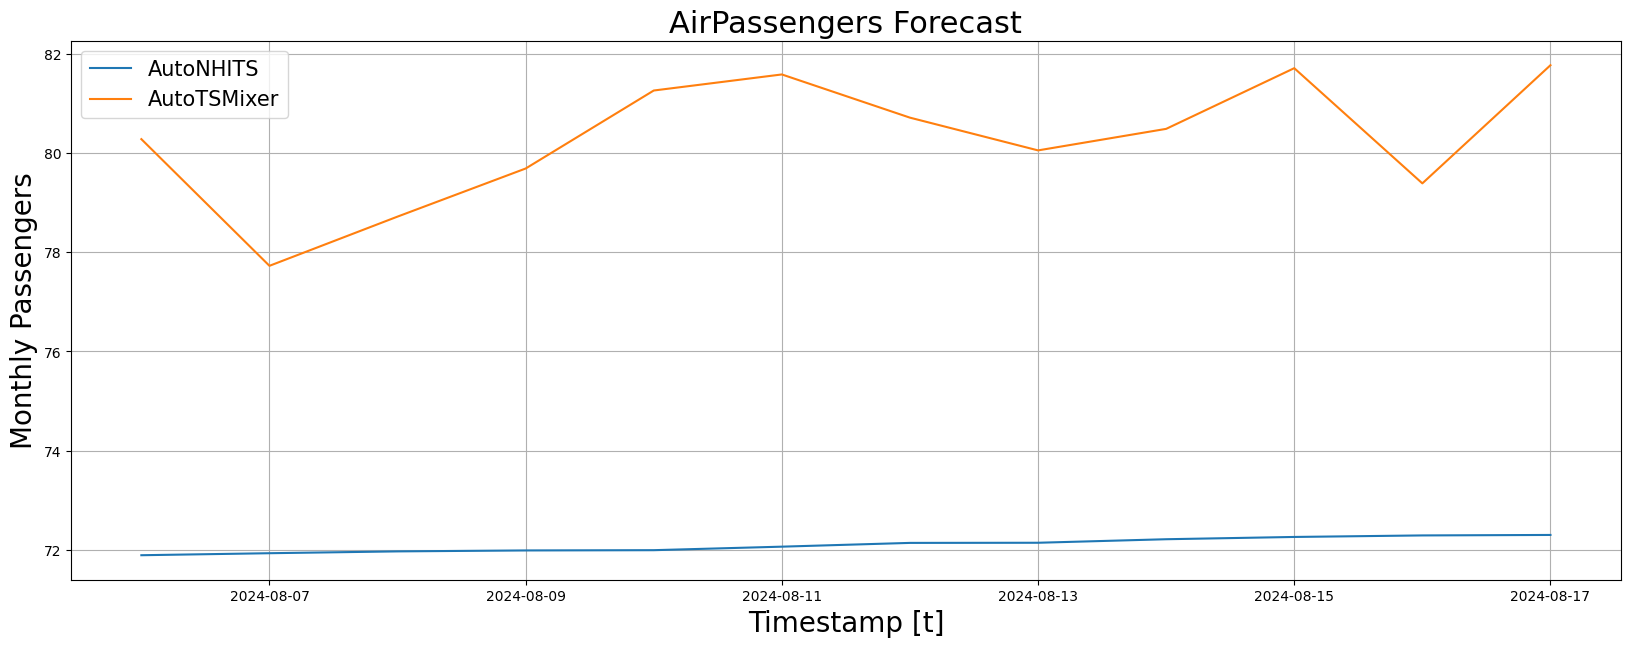

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).reset_index()

#plt.plot(plot_df['ds'], plot_df['y'], label='y')
plt.plot(Y_hat_df_optuna['ds'], Y_hat_df_optuna['AutoNHITS'], label='AutoNHITS')
plt.plot(Y_hat_df_optuna['ds'], Y_hat_df_optuna['AutoTSMixer'], label='AutoTSMixer')

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

## Feature Engineering

In [184]:
X_df = gasoline_data.drop(columns=['High', 'Low']).rename({'Close' : 'Gas'}, axis=1).merge(
    dollar_data.drop(columns=['High', 'Low']).rename({'Close' : 'DXY'}, axis=1), on='Date').merge(
    gold_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Gold(CMX)'}, axis=1), on='Date').merge(
    silver_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Silver(CMX)'}, axis=1), on='Date').merge(
    platinum_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Platinum(NMX)'}, axis=1), on='Date').merge(
    palladium_price_data.drop(columns=['High', 'Low']).rename({'Close' : 'Palladium(NMX)'}, axis=1), on='Date').merge(
    us_bond_data.drop(columns=['High', 'Low']).rename({'Close' : 'USBond'}, axis=1), on='Date').merge(
    sp500_data.drop(columns=['High', 'Low']).rename({'Close' : 'S&P500'}, axis=1), on='Date').merge(
    gold_miners_data.drop(columns=['High', 'Low']).rename({'Close' : 'GoldMiners'}, axis=1), on='Date').merge(
    gpr_data[['Date', 'GPRD']])

y_df = brent_futures_data[['Date','Close']].rename({'Close' : 'BrFu'}, axis=1)

df = X_df.merge(y_df, on ='Date').rename({'Date' : 'ds'}, axis=1)
df['ds'] = pd.to_datetime(df['ds'])

y_df = df['BrFu']

df.drop(columns=['BrFu'], inplace=True)

In [187]:
df['unique_id'] = 1

y_df = y_df.rename({'BrFu' : 'y'})

In [189]:
from tsfresh import extract_features
extracted_features = extract_features(df, column_id="unique_id", column_sort="ds")

Feature Extraction: 100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


In [193]:
df

ds     Gas         DXY  Gold(CMX)  Silver(CMX)  Platinum(NMX)  \
0    2024-08-05  2.3336  102.690002     2444.4       27.207          915.5   
1    2024-08-02  2.3176  103.209999     2469.8       28.392          967.6   
2    2024-08-01  2.3980  104.419998     2480.8       28.477          970.5   
3    2024-07-31  2.4425  104.099998     2473.0       28.938          986.4   
4    2024-07-30  2.3443  104.550003     2451.9       28.525          971.0   
...         ...     ...         ...        ...          ...            ...   
2496 2014-08-29  2.6229   82.750000     1287.4       19.492         1424.7   
2497 2014-08-28  2.5908   82.480003     1290.4       19.609         1425.2   
2498 2014-08-27  2.5905   82.430000     1283.4       19.475         1419.9   
2499 2014-08-26  2.6001   82.650002     1285.2       19.459         1419.6   
2500 2014-08-25  2.5954   82.550003     1278.9       19.431         1418.4   

      Palladium(NMX)    USBond   S&P500  GoldMiners        GPRD  unique_id  
0             826.10  125.4062  5186.33       35.34  210.206711          1  
1             882.50  125.0625  5346.56       36.48  207.799438          1  
2             895.10  122.5312  5446.68       37.27  139.878098          1  
3             925.20  120.7812  5522.30       37.93  135.206848          1  
4             881.70  120.1875  5436.44       36.95   95.696396          1  
...              ...       ...      ...         ...         ...        ...  
2496          909.55  140.0938  2003.37       26.69  157.336334          1  
2497          898.10  141.7188  1996.74       26.46   97.534706          1  
2498          894.70  141.1562  2000.12       26.11  143.082108          1  
2499          890.15  140.5312  2000.02       26.19  118.143707          1  
2500          891.50  140.7188  1997.92       25.62  167.600159          1  

[2501 rows x 12 columns]

In [190]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y_df)

e:\VM\miniconda3\envs\multi-its\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['Gas__query_similarity_count__query_None__threshold_0.0'
 'DXY__query_similarity_count__query_None__threshold_0.0'
 'Platinum(NMX)__query_similarity_count__query_None__threshold_0.0'
 'Palladium(NMX)__query_similarity_count__query_None__threshold_0.0'
 'Silver(CMX)__query_similarity_count__query_None__threshold_0.0'
 'Gold(CMX)__query_similarity_count__query_None__threshold_0.0'
 'USBond__query_similarity_count__query_None__threshold_0.0'
 'S&P500__query_similarity_count__query_None__threshold_0.0'
 'GoldMiners__query_similarity_count__query_None__threshold_0.0'
 'GPRD__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


AssertionError: X and y must contain the same number of samples.

In [ ]:
extracted_features

y__variance_larger_than_standard_deviation  y__has_duplicate_max  \
Dated                                         0.0                   0.0   

       y__has_duplicate_min  y__has_duplicate  y__sum_values  y__abs_energy  \
Dated                   0.0               1.0   4.547474e-13         2501.0   

       y__mean_abs_change  y__mean_change  y__mean_second_derivative_central  \
Dated            0.062532        0.000441                          -0.000012   

       y__median  ...  GPRD__fourier_entropy__bins_5  \
Dated  -0.142643  ...                       0.170467   

       GPRD__fourier_entropy__bins_10  GPRD__fourier_entropy__bins_100  \
Dated                        0.390338                         1.894835   

       GPRD__permutation_entropy__dimension_3__tau_1  \
Dated                                       1.791383   

       GPRD__permutation_entropy__dimension_4__tau_1  \
Dated                                       3.171978   

       GPRD__permutation_entropy__dimension_5__tau_1  \
Dated                                       4.758524   

       GPRD__permutation_entropy__dimension_6__tau_1  \
Dated                                       6.418777   

       GPRD__permutation_entropy__dimension_7__tau_1  \
Dated                                       7.498423   

       GPRD__query_similarity_count__query_None__threshold_0.0  \
Dated                                                NaN         

       GPRD__mean_n_absolute_max__number_of_maxima_7  
Dated                                       6.830437  

[1 rows x 9396 columns]

## Save and load models

In [160]:
nf.save(path='./checkpoints/test_run/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

In [158]:
nf2 = NeuralForecast.load(path='./checkpoints/test_run/')
Y_hat_df = nf2.predict().reset_index()
Y_hat_df.head()

e:\VM\miniconda3\envs\multi-its\lib\site-packages\neuralforecast\common\_base_model.py:444: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  content = torch.load(f, **kwargs)
S

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.66it/s]


e:\VM\miniconda3\envs\multi-its\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


unique_id         ds  AutoNHITS  AutoTSMixer
0     Dated 2024-08-06  71.889229    80.282181
1     Dated 2024-08-07  71.929710    77.726891
2     Dated 2024-08-08  71.966599    78.719620
3     Dated 2024-08-09  71.985695    79.689644
4     Dated 2024-08-10  71.991013    81.262947

In [159]:
Y_hat_df

unique_id         ds  AutoNHITS  AutoTSMixer
0      Dated 2024-08-06  71.889229    80.282181
1      Dated 2024-08-07  71.929710    77.726891
2      Dated 2024-08-08  71.966599    78.719620
3      Dated 2024-08-09  71.985695    79.689644
4      Dated 2024-08-10  71.991013    81.262947
5      Dated 2024-08-11  72.061859    81.586983
6      Dated 2024-08-12  72.137817    80.715485
7      Dated 2024-08-13  72.140602    80.055084
8      Dated 2024-08-14  72.211769    80.489311
9      Dated 2024-08-15  72.257744    81.713593
10     Dated 2024-08-16  72.288536    79.390053
11     Dated 2024-08-17  72.298134    81.773094

# Test

In [2]:
import pandas as pd

test = pd.read_csv('artifacts\cf12e42a-5a61-4bb0-bce2-0c0b9b246e53\dataset.csv')

In [12]:
# Select columns that end with 'Close' except for 'Date'
close_columns_df = pd.concat([test['Date'], test.filter(regex=r'Close$')], axis=1)

In [16]:
pd.to_datetime(close_columns_df['Date'])

0      2014-08-25
1      2014-08-26
2      2014-08-27
3      2014-08-28
4      2014-08-29
          ...    
2495   2024-07-29
2496   2024-07-30
2497   2024-07-31
2498   2024-08-01
2499   2024-08-02
Name: Date, Length: 2500, dtype: datetime64[ns]

In [9]:
import pickle as pkl
import pandas as pd

object = 'artifacts/498f27cb-5e23-4503-9323-a4333f22becf/model/dataset.pkl'

df = pd.read_pickle(object)
df

TimeSeriesDataset(n_data=2,500, n_groups=1)

In [8]:
object

TimeSeriesDataset(n_data=2,500, n_groups=1)